# Applying ML to Predict Hotel Booking Cancellations

## The Project:
The hospitality industry relies heavily on accurate demand forecasting to optimize revenue and manage inventory. One significant challenge for hotels is the prediction of cancellations, which can disrupt business operations, lead to lost revenue, and impact customer satisfaction. Machine learning techniques offer a promising solution for predicting cancellations and mitigating their effects.

Hence, in this project, I aim to develop an ML model for hotel cancellation prediction, leveraging historical booking data and other relevant features. I will explore various algorithms and techniques, including Naive Bayes, random forest, gradient boosting, to identify the most effective approach for predicting cancellations. Ultimately, my goal is to provide a valuable tool for hotels to optimize their revenue management and improve customer satisfaction by accurately predicting and managing cancellations.

## The Dataset:

The dataset has been collected from <a href="https://www.sciencedirect.com/science/article/pii/S2352340918315191">ScienceDirect</a> and consists of hotel demand data for 2 hotels (H1 and H2) in Europe. Both datasets share the same structure, with 31 variables describing the 40,060 observations of H1 and 79,330 observations of H2. Each observation represents a hotel booking.

## Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import eli5

## Import and Verify the Data

In [2]:
data = pd.read_csv('hotel_bookings.csv')

In [3]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

As can be seen, the data has been loaded properly. There are a total of 119390 rows of data spread across 32 columns as expected.

The data types seem to be okay and do not require any changes at the moment.

## Data Cleaning

### Dealing with Null Values

In machine learning, null or missing values refer to data points that are not available or not recorded in a dataset. These values can be caused by various reasons, such as data entry errors, incomplete records, or data processing issues.

Null values can cause errors in the analysis and prediction of machine learning models, as many algorithms cannot handle missing data. Therefore, it is important to properly deal with null values in a dataset before training the model.

Dealing with null values properly can improve the accuracy and reliability of the model's output, as it ensures that the machine learning algorithm is making predictions based on the maximum amount of available data. Additionally, properly handling null values can help prevent bias in the machine learning model and improve the overall quality of the analysis.

In [5]:
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [6]:
# Replace missing values:
# agent: If no agency is given, booking was most likely made without one.
# company: If none given, it was most likely private.
# rest should be self-explanatory.

replacements = {"children:": 0.0, "country": "Unknown", "agent": 0, "company": 0}

data = data.fillna(replacements)

# "meal" contains values "Undefined", which is equal to SC.
data["meal"].replace("Undefined", "SC", inplace=True)

# Some rows contain entries with 0 adults, 0 children and 0 babies.
# I'm dropping these entries with no guests.
zero_guests = data.loc[data["adults"] + data["children"] + data["babies"]==0].index
data.drop(zero_guests, inplace=True)

In [7]:
data.shape

(119210, 32)

After dealing with the null values, we are left with 119210 rows from the initial 119390.

### Dealing with Duplicates

Dealing with duplicate values is important for machine learning projects as they can affect the quality of the dataset and lead to biased or inaccurate model predictions. Removing or handling duplicate values properly can help ensure that the machine learning model is trained on high-quality data and can make reliable predictions.

Duplicate values occur when there are identical or nearly identical data points in a dataset. These duplicates can occur due to errors in data entry or data collection, or because of the way the data was merged from multiple sources. In some cases, duplicates can be intentional, such as when a dataset contains multiple measurements of the same variable.

Duplicate values can cause several issues in machine learning projects. Firstly, they can lead to over-representation of certain data points, which can create bias in the analysis and predictions of the machine learning model. Secondly, duplicates can increase the computational complexity of the analysis, as the same data points are being analyzed multiple times. Finally, duplicates can cause issues with model validation, as the same data points may appear in both the training and testing datasets, leading to over-optimistic performance metrics.

Handling duplicate values properly can improve the quality of the dataset and the accuracy of the machine learning model. It can also help ensure that the model is making unbiased predictions based on high-quality data. Therefore, it is important to carefully consider how to handle duplicate values in a machine learning project.

In [8]:
data.duplicated().sum()

31980

In [9]:
data.drop_duplicates(inplace=True)

In [10]:
data.shape

(87230, 32)

As can be seen, we had over 31000 duplicate values, accounting about 27% of the total data. After dropping them, we are left with 87230 rows of data.

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in any machine learning project, as it helps to understand the data, identify patterns, and select appropriate features for training the model. EDA provides insights into the relationships between the variables in the dataset, which can help to optimize the machine learning model and improve its predictive performance.

EDA involves a range of statistical and graphical techniques to summarize and visualize the dataset. These techniques include descriptive statistics, correlation analysis, scatter plots, histograms, and box plots, among others. Through these techniques, EDA can identify missing values, outliers, and anomalies in the dataset, and help to prepare the data for modeling.

The importance of EDA in machine learning projects can be summarized in the following points:

1. **Data Understanding**: EDA helps to understand the characteristics and structure of the data, including the distribution of the variables, the presence of outliers and missing values, and the relationships between the variables. This understanding can help to determine the appropriate data preprocessing and feature engineering techniques required for the machine learning model. <br><br>

2. **Feature Selection**: EDA can help to identify the most important features for the machine learning model. By analyzing the correlations between the features and the target variable, EDA can help to select the most relevant features and eliminate the redundant ones. This can improve the model's performance and reduce its computational complexity. <br><br>

3. **Model Optimization**: EDA can help to optimize the machine learning model by identifying the best hyperparameters for the algorithm. By analyzing the performance of the model with different hyperparameter values, EDA can help to identify the best parameter settings for the algorithm, improving its predictive accuracy and generalization.

### Origin of Guests

In [11]:
guest_countries = data['country'].value_counts()
guest_countries

PRT    27355
GBR    10424
FRA     8823
ESP     7244
DEU     5385
       ...  
MMR        1
BFA        1
CYM        1
MLI        1
KHM        1
Name: country, Length: 178, dtype: int64

Since there are a lot of countries, but only a few have too many guests coming from there, I will only look at the top 10 countries by bookings.

In [12]:
top_10 = guest_countries.head(10)
top_10 = pd.DataFrame({'country': top_10.index.values, 'guests': top_10.values})
others = sum(guest_countries[10:])
top_10 = top_10.append({'country': 'other', 'guests': others}, ignore_index=True)

/var/folders/7p/m7gs_hkn58qbs70h8pztg9480000gn/T/ipykernel_81084/2589386483.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_10 = top_10.append({'country': 'other', 'guests': others}, ignore_index=True)


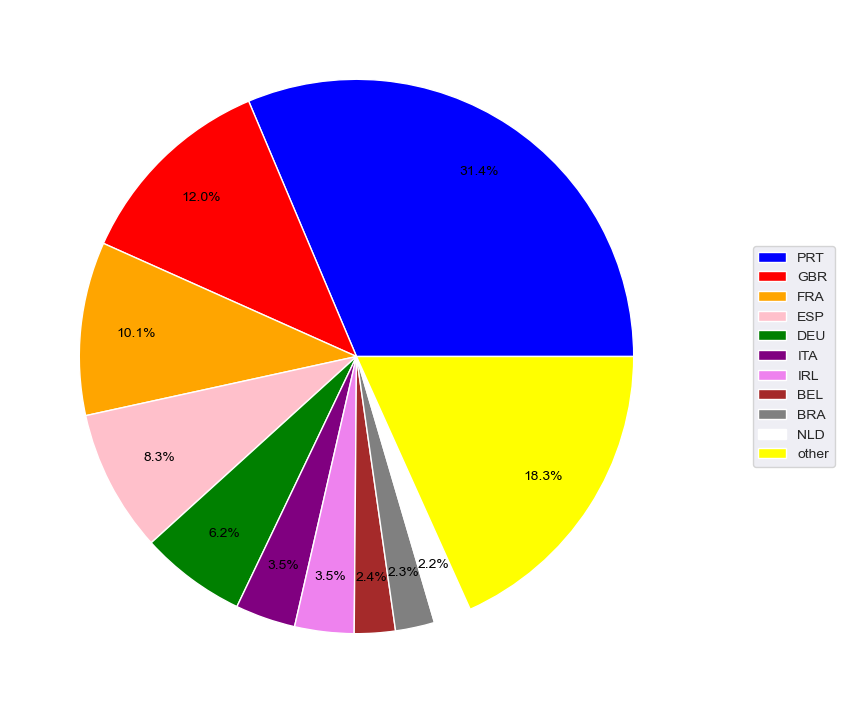

In [13]:
plt.figure(figsize=(9,9))
plt.pie(top_10['guests'], autopct='%1.1f%%', textprops={'color':'black'}, pctdistance=0.8, colors=['blue', 'red', 'orange', 'pink', 'green', 'purple', 'violet', 'brown', 'gray', 'white', 'yellow'])
plt.legend(top_10['country'], loc='right', bbox_to_anchor=(1.2,0.5))
plt.show()

As can be seen from the chart, most guests hail from Europe, with Portugal bringing in more than 31% of the total guests.

### Cost of Rooms per Night

Both hotels have different room types and different meal arrangements. Seasonal factors are also important. So the prices vary a lot.

Since no currency information is given, but it is said that the hotels are in Europe, I assume that all prices are in EUR.

In [14]:
print(f'''Across all room types and meals, the average room price per person per night are as follows:

Resort Hotel: {round(data[data['hotel']=='Resort Hotel']['adr'].mean(), 2)} €
City Hotel: {round(data[data['hotel']=='City Hotel']['adr'].mean(), 2)} €
''')

Across all room types and meals, the average room price per person per night are as follows:

Resort Hotel: 99.06 €
City Hotel: 111.27 €



In [15]:
room_prices = data[['hotel', 'reserved_room_type', 'adr']].sort_values(by = 'reserved_room_type')

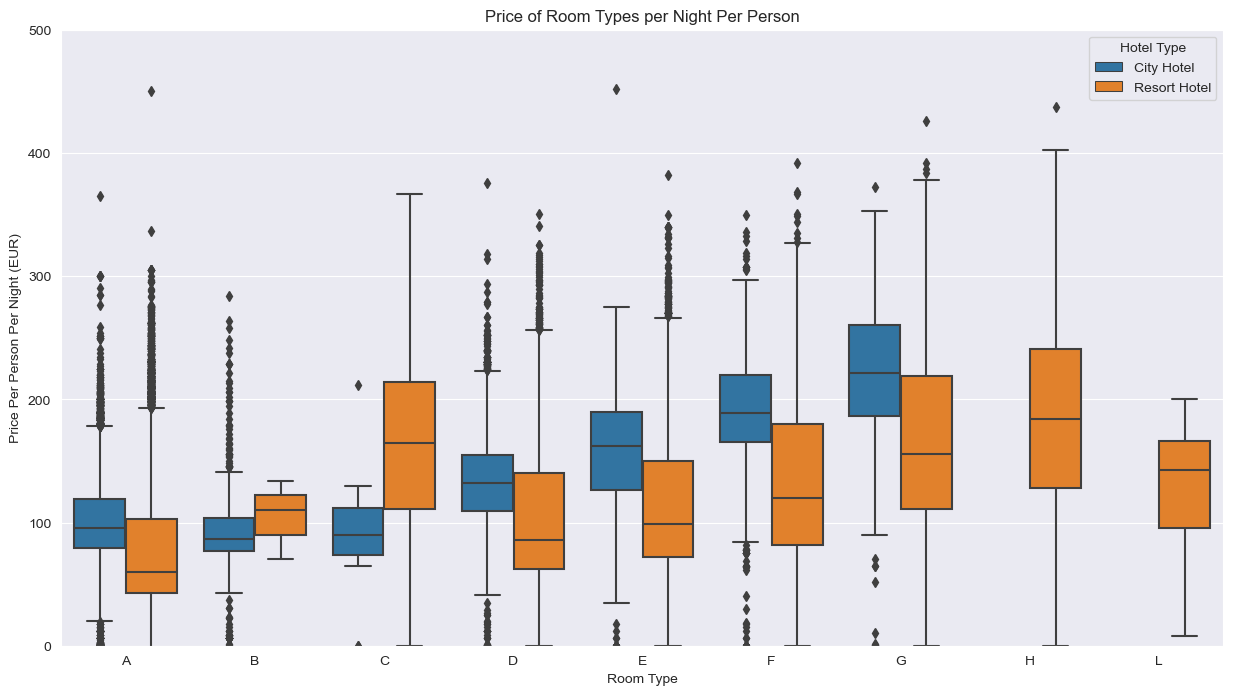

In [16]:
plt.figure(figsize=(15,8))
sns.boxplot(data=room_prices, x='reserved_room_type', y='adr', hue='hotel')
plt.ylabel('Price Per Person Per Night (EUR)')
plt.xlabel('Room Type')
plt.title('Price of Room Types per Night Per Person')
plt.ylim([0, 500])
plt.legend(title='Hotel Type', bbox_to_anchor=(1,1))
plt.show()

This figure shows the average price per room, depending on its type and the standard deviation.
Note that due to data anonymization rooms with the same type letter may not necessarily be the same across hotels.

### Change of Hotel Rate Throughout the Year

To keep it simple, I'm using the average price per night and person, regardless of the room type and meal.

In [17]:
monthly_price = data[["hotel", "arrival_date_month", "adr"]].sort_values("arrival_date_month")

#order by month
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

monthly_price['arrival_date_month'] = pd.Categorical(monthly_price["arrival_date_month"], categories=months, ordered=True)

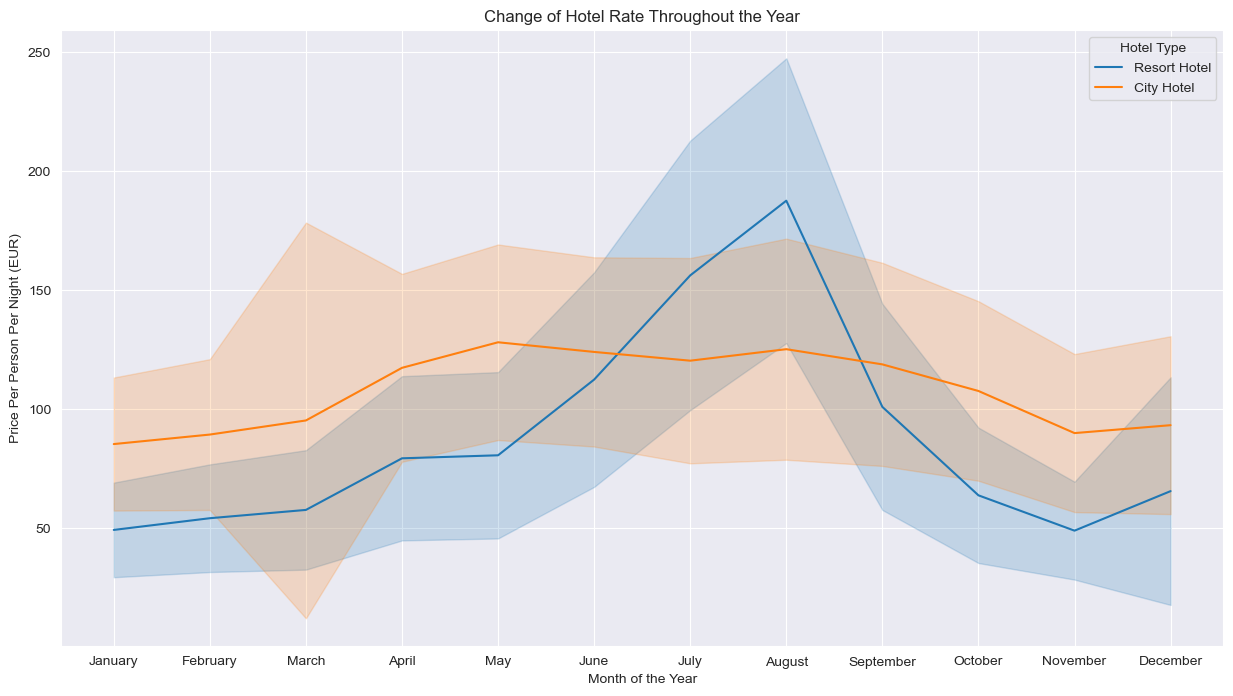

In [18]:
plt.figure(figsize=(15, 8))

sns.lineplot(data=monthly_price, x='arrival_date_month', y='adr', hue='hotel', errorbar='sd')
plt.ylabel('Price Per Person Per Night (EUR)')
plt.xlabel('Month of the Year')
plt.title('Change of Hotel Rate Throughout the Year')
plt.legend(title='Hotel Type')
plt.show()

This clearly shows that the prices in the Resort hotel are much higher during the summer (no surprise here).
The price of the city hotel varies less and is most expensive during spring and autumn.

### Length of Stay

In [19]:
hotel_stay = data[data['is_canceled']==0][['hotel', 'stays_in_week_nights', 'stays_in_weekend_nights']]
hotel_stay['total_stay_nights'] = hotel_stay['stays_in_week_nights'] + hotel_stay['stays_in_weekend_nights']
hotel_stay.sort_values('total_stay_nights')

,hotel,stays_in_week_nights,stays_in_weekend_nights,total_stay_nights
0,Resort Hotel,0,0,0
118963,City Hotel,0,0,0
3271,Resort Hotel,0,0,0
814,Resort Hotel,0,0,0
815,Resort Hotel,0,0,0
...,...,...,...,...
1655,Resort Hotel,33,13,46
54704,City Hotel,34,14,48
33924,Resort Hotel,40,16,56
14037,Resort Hotel,42,18,60


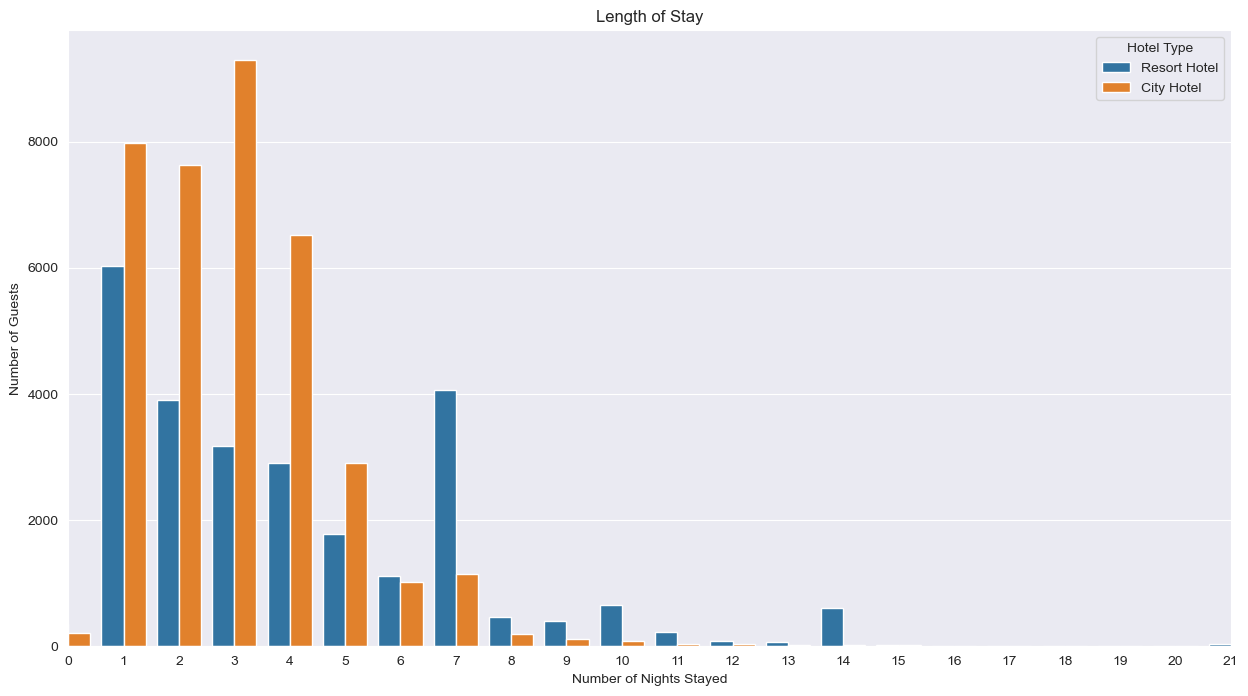

In [20]:
plt.figure(figsize=(15,8))

sns.countplot(data=hotel_stay, x='total_stay_nights', hue='hotel')
plt.xlim([0, 21])
plt.xlabel('Number of Nights Stayed')
plt.ylabel('Number of Guests')
plt.title('Length of Stay')
plt.legend(title='Hotel Type')

plt.show()

For the city hotel there is a clear preference for 1-4 nights.
For the resort hotel, 1-4 nights are also often booked, but 7 nights also stand out as being very popular.

### Bookings by Market Segment

In [21]:
segments = data['market_segment'].value_counts()
segments

Online TA        51553
Offline TA/TO    13855
Direct           11780
Groups            4922
Corporate         4200
Complementary      692
Aviation           226
Undefined            2
Name: market_segment, dtype: int64

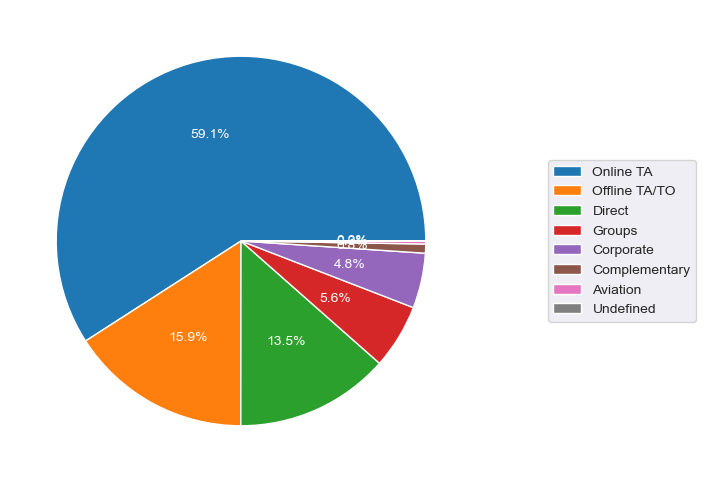

In [22]:
plt.figure(figsize=(6,6))
plt.pie(segments, autopct='%1.1f%%', textprops={'color':'white'})
plt.legend(segments.index, loc='right', bbox_to_anchor=(1.5,0.5))
plt.show()

The most bookings are made by online travel agencies (59.1%).

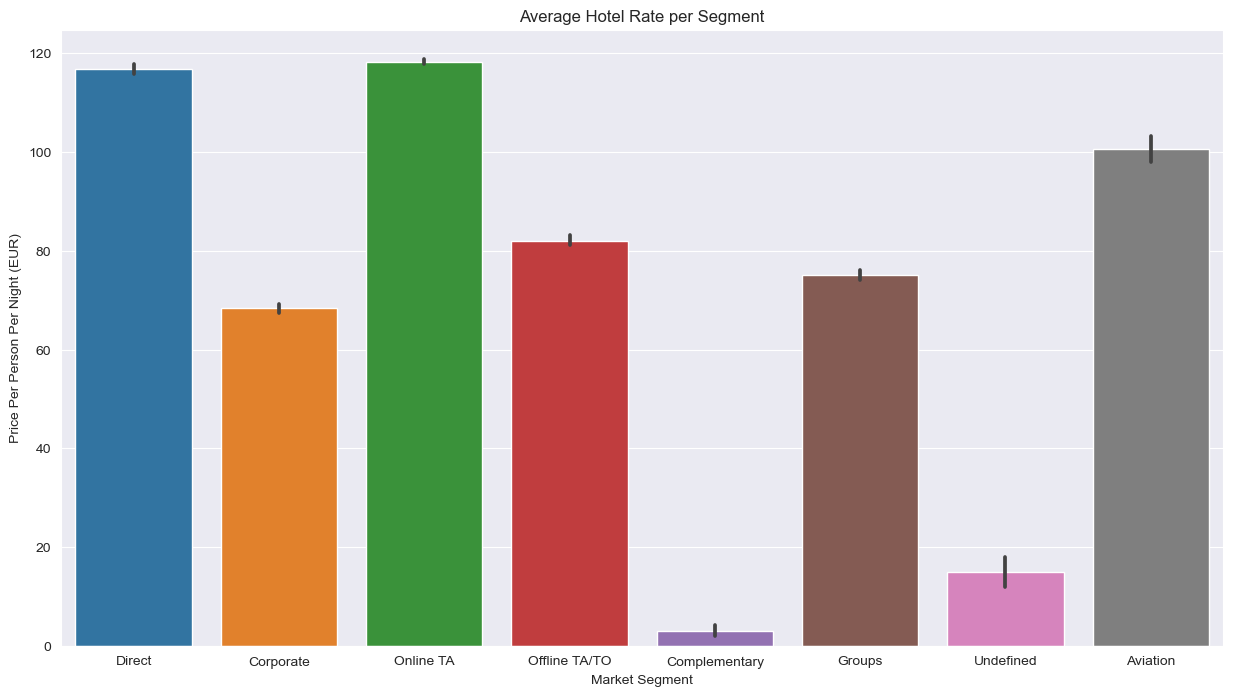

In [23]:
plt.figure(figsize=(15,8))

sns.barplot(data, x='market_segment', y='adr', estimator='mean')
plt.xlabel('Market Segment')
plt.ylabel('Price Per Person Per Night (EUR)')
plt.title('Average Hotel Rate per Segment')
plt.show()

People booking directly and through an online travel agency pay the highest rate per night. On the other hand, group bookings have pretty low nightly rates.

However, what is surprising is that airlines pay the 3rd highest rate. Why is that?

### Analysing Airline Data

In [24]:
airline_data = data[data['market_segment'] == 'Aviation'][['is_canceled', 'adults', 'lead_time', 'adr']]

non_airline_data = data[data['market_segment'] != 'Aviation'][['is_canceled', 'adults', 'lead_time', 'adr']]

In [25]:
airline_data.describe()

,is_canceled,adults,lead_time,adr
count,226.000000,226.000000,226.000000,226.000000
mean,0.199115,1.013274,4.296460,100.613628
std,0.400221,0.114701,4.500438,19.883457
min,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,95.000000
50%,0.000000,1.000000,3.000000,95.000000
75%,0.000000,1.000000,5.750000,110.000000
max,1.000000,2.000000,23.000000,193.500000


In [26]:
non_airline_data.describe()

,is_canceled,adults,lead_time,adr
count,87004.000000,87004.000000,87004.000000,87004.000000
mean,0.275436,1.881615,80.167590,106.533368
std,0.446736,0.620933,86.083497,54.952346
min,0.000000,0.000000,0.000000,-6.380000
25%,0.000000,2.000000,12.000000,72.097500
50%,0.000000,2.000000,50.000000,98.250000
75%,1.000000,2.000000,125.000000,134.100000
max,1.000000,55.000000,737.000000,5400.000000


From the above results, it can be seen:

- Lead time for bookings from Aviation is very short: Mean 4 days vs. 80 days for other bookings<br><br>

- Airlines need a place for their crews to stay so there's lesser cancellations<br><br>

- Airline personnel usually gets one room per person - more total rooms required compared to families<br><br>

### Booking Cancellations

In [27]:
total_cancel = data['is_canceled'].sum()
total_cancel_percent = total_cancel / data.shape[0] * 100

In [28]:
resort_total_cancel = data[data['hotel'] == 'Resort Hotel']['is_canceled'].sum()
resort_total_cancel_percent = resort_total_cancel / data[data['hotel'] == 'Resort Hotel'].shape[0] * 100

In [29]:
city_total_cancel = data[data['hotel'] == 'City Hotel']['is_canceled'].sum()
city_total_cancel_percent = city_total_cancel / data[data['hotel'] == 'City Hotel'].shape[0] * 100

In [30]:
print(f'Total bookings cancelled: {total_cancel} ({round(total_cancel_percent, 2)})')
print(f'Resort hotel bookings cancelled: {resort_total_cancel} ({round(resort_total_cancel_percent, 2)})')
print(f'City hotel bookings cancelled: {city_total_cancel} ({round(city_total_cancel_percent, 2)})')

Total bookings cancelled: 24009 (27.52)
Resort hotel bookings cancelled: 7974 (23.48)
City hotel bookings cancelled: 16035 (30.1)


In [31]:
res_book_per_month = data[data["hotel"] == "Resort Hotel"].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = data[data["hotel"] == "Resort Hotel"].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = data[data["hotel"] == "City Hotel"].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = data[data["hotel"] == "City Hotel"].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancellations": list(res_cancel_per_month.values)})

cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancellations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancellations"] / full_cancel_data["Bookings"] * 100

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=months, ordered=True)

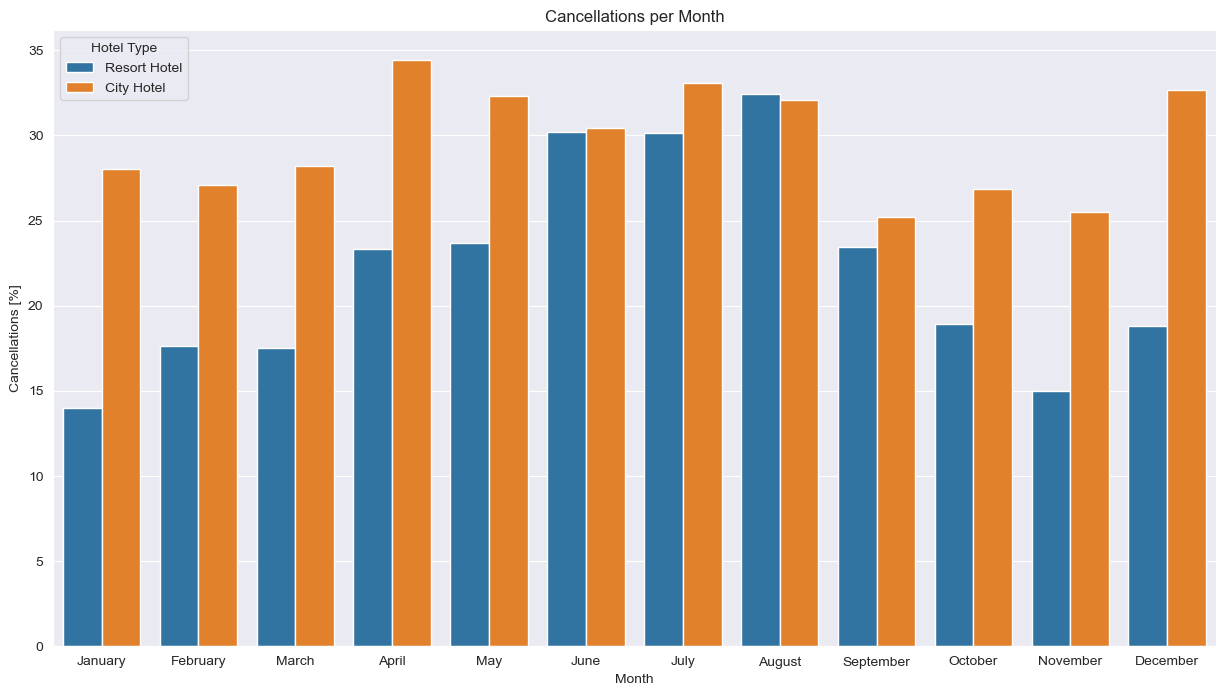

In [32]:
plt.figure(figsize=(15,8))

sns.barplot(data=full_cancel_data, x='Month', y='cancel_percent', hue='Hotel')
plt.xlabel('Month')
plt.ylabel('Cancellations [%]')
plt.title('Cancellations per Month')
plt.legend(title='Hotel Type')

plt.show()

For the City hotel the relative number of cancellations is around 30 % throughout the year.
For the Resort hotel it is highest in the summer and lowest during the winter.

## Prediction Models

Now that we are done with the EDA steps and have gained sufficient knowledge about the dataset population, we can proceed to building machine learning models that can accurately predict if a booking will be cancelled based on some specific variables.

### Significant Numerical Features

In [33]:
cancel_corr = data.corr(numeric_only=True)['is_canceled']
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.184515
required_car_parking_spaces       0.184456
adr                               0.127233
total_of_special_requests         0.120794
booking_changes                   0.093236
is_repeated_guest                 0.088764
arrival_date_year                 0.088020
stays_in_week_nights              0.084159
adults                            0.080271
company                           0.075314
children                          0.067209
stays_in_weekend_nights           0.060992
previous_bookings_not_canceled    0.052178
previous_cancellations            0.051501
babies                            0.020627
arrival_date_day_of_month         0.005449
days_in_waiting_list              0.004710
arrival_date_week_number          0.001691
agent                             0.001145
Name: is_canceled, dtype: float64

From this list, it is apparent that lead_time, required_car_parking_spaces, adr, total_of_special_requests and booking_changes are the 5 most important numerical features.

However, to predict whether a booking will be canceled or not, the number of booking changes is a possible source of leakage, because this information can change over time.

I will also not include days_in_waiting_list, arrival_date_year and reservation_status.

### Data Preprocessing


In [34]:
# manually choose columns to include
# some columns are excluded to make the model more general and to prevent leakage
# (arrival_date_year, assigned_room_type, booking_changes, reservation_status, country, days_in_waiting_list)

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type", "country"]

In [35]:
# Separate features and target value
features = num_features + cat_features
X = data.drop(["is_canceled"], axis=1)[features]
y = data["is_canceled"]

In [36]:
# preprocess numerical feats:
# scale using Standard Scaler to remove bias
# for most num cols, except the dates, 0 is the most logical choice as fill value and here no dates are missing.
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant")),
    ("scaler", StandardScaler())])

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

In [37]:
# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [38]:
# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 5 # 4 = 80% train, 20% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

### Building Base Models

In [39]:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1,max_iter=10000)),
               ("LGBM_model", LGBMClassifier(random_state=42, n_jobs=-1))]

In [40]:
# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps,
                                 X, y,
                                 cv=split,
                                 scoring='accuracy',
                                 n_jobs=-1)

    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)

    print(f"{name}: avg. cross validation accuracy score: {mean_score}, min: {min_score}, max: {max_score}")

DT_model: avg. cross validation accuracy score: 0.795, min: 0.7924, max: 0.797
RF_model: avg. cross validation accuracy score: 0.8419, min: 0.8386, max: 0.8444
LR_model: avg. cross validation accuracy score: 0.7905, min: 0.7876, max: 0.7965
LGBM_model: avg. cross validation accuracy score: 0.8368, min: 0.8353, max: 0.8402


### Enhanced RF Model

The RandomForest model performs best. Let's do some hypertuning to enhance the accuracy further.

In [41]:
# Enhanced RF model with the best parameters I found:
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe,
                                 X, y,
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
# output:
min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)

print(f"Enhanced RF model cross validation accuracy score: {mean_score}, min: {min_score}, max: {max_score}")

Enhanced RF model cross validation accuracy score: 0.8463, min: 0.844, max: 0.8476


## Evaluating Importance of Certain Features

In [42]:
# fit model(pipeline) so values can be accessed:
model_pipe.fit(X,y)

# Names of all (encoded) features are needed.
# Get names of columns from One Hot Encoding:
onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names_out(input_features=cat_features))

# Add num_features for full list.
# Order must be as in definition of X, where num_features are first:
feat_imp_list = num_features + onehot_columns

# show 10 most important features, provide names of features:
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
feat_imp_df.head(10)

,feature,weight,std
0,lead_time,0.154353,0.008054
1,adr,0.095607,0.004305
2,arrival_date_day_of_month,0.068340,0.002053
3,agent,0.063138,0.014138
4,total_of_special_requests,0.062665,0.011450
5,arrival_date_week_number,0.059141,0.002457
6,country_PRT,0.055472,0.013648
7,market_segment_Online TA,0.044566,0.019330
8,stays_in_week_nights,0.042089,0.002911
9,required_car_parking_spaces,0.034943,0.002876


As can be seen from the table, lead_time and adr were the most significant in determining hotel cancellations. Let's dive deeper into these features.

### Lead Time

In [43]:
lead_cancel_data = data.groupby("lead_time")["is_canceled"].describe()

# use only lead_times wih more than 10 bookings for graph:
lead_cancel_data_10 = lead_cancel_data[lead_cancel_data["count"] >= 10]

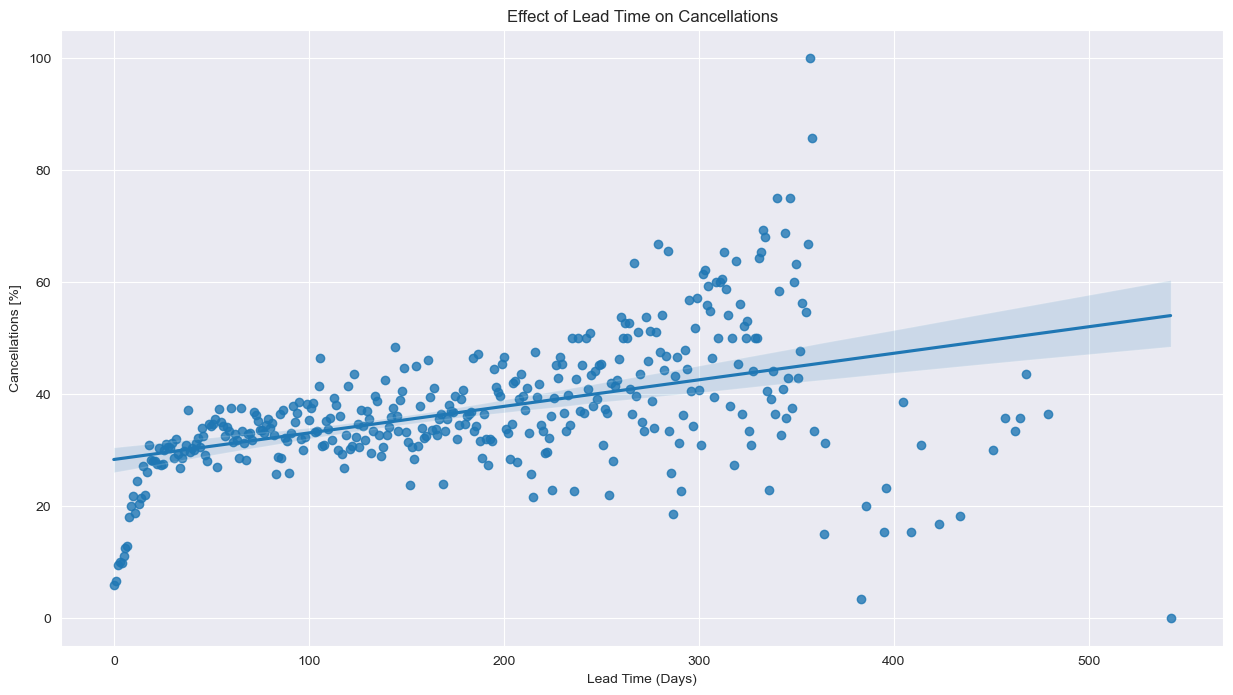

In [44]:
plt.figure(figsize=(15,8))

sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10['mean'].values * 100)
plt.xlabel("Lead Time (Days)")
plt.ylabel("Cancellations [%]")
plt.title('Effect of Lead Time on Cancellations')

plt.show()

Bookings made a few days before the arrival date are rarely canceled, whereas bookings made over 300 days in advance are canceled very often.

### ADR

In [45]:
adr_cancel_data = data.groupby("adr")["is_canceled"].describe()

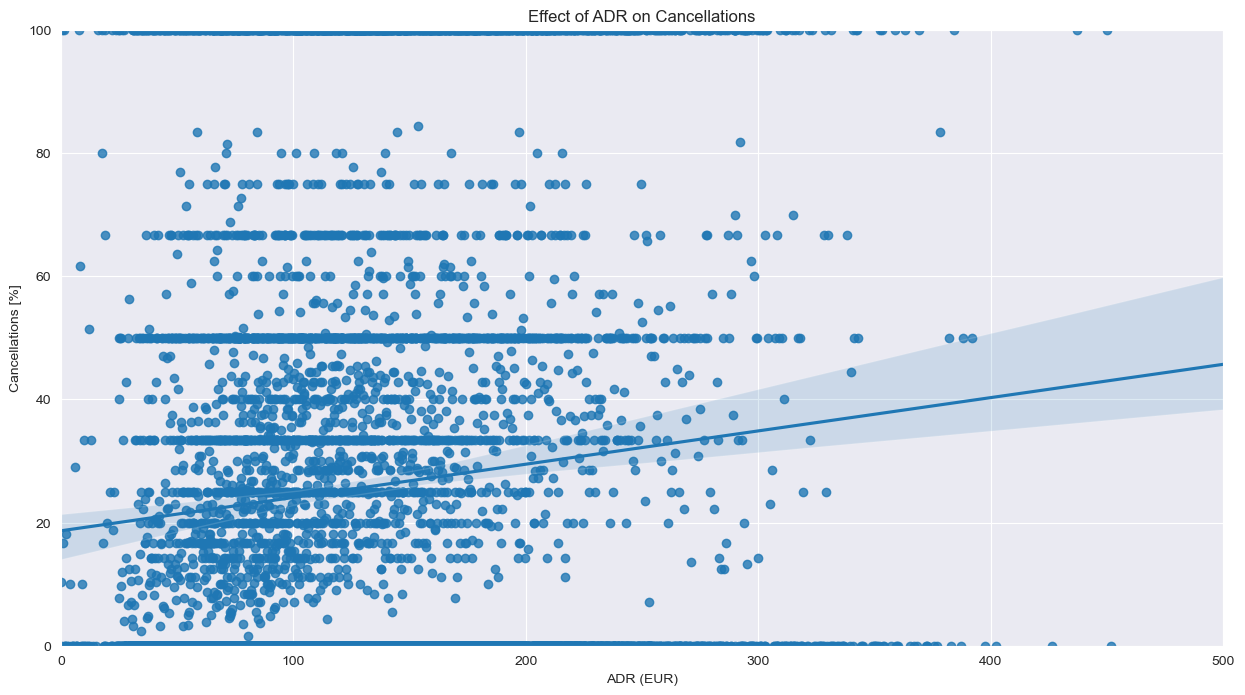

In [46]:
plt.figure(figsize=(15,8))

sns.regplot(x=adr_cancel_data.index, y=adr_cancel_data['mean'].values * 100)
plt.xlabel("ADR (EUR)")
plt.ylabel("Cancellations [%]")
plt.xlim([0,500])
plt.ylim([0,100])
plt.title('Effect of ADR on Cancellations')

plt.show()

It can be seen that, as the nightly rate per person increases, so does the rate of cancellations.

## Conclusion

In conclusion, my machine learning project on hotel cancellation prediction has demonstrated the potential of data analytics to address critical challenges in the hospitality industry. By leveraging historical booking data and relevant features, I developed and evaluated several ML models for predicting cancellations.

The results indicate that the random forest model outperformed other algorithms, achieving a high accuracy rate and providing valuable insights into cancellation patterns and trends. The development of this model can enable hotels to optimize their revenue management and improve operational efficiency by predicting and managing cancellations effectively.

Moreover, my project highlights the importance of data-driven decision-making in the hospitality industry and the potential of machine learning techniques to support business operations.

With further refinement and application, this approach could lead to a significant improvement in the profitability and competitiveness of hotels, benefiting both customers and stakeholders in the industry.